## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

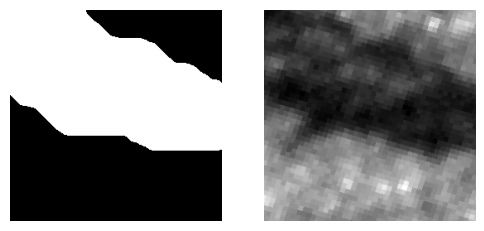

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.8),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.0002, dtype=torch.float64), tensor(1., dtype=torch.float64))

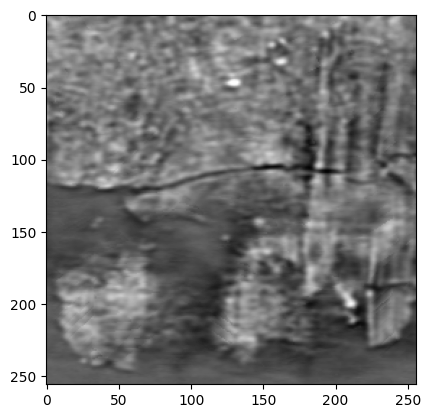

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=1)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        pred_mask = F.interpolate(pred_mask, size=(256, 256), mode='nearest')
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 14.1GB  LR : 4.00E-06  Loss: 0.6818: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                           
Val Loss: 0.6695: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.133341
Threshold : 0.25	FBeta : 0.134545
Threshold : 0.30	FBeta : 0.136953
Threshold : 0.35	FBeta : 0.142315
Threshold : 0.40	FBeta : 0.151492
Threshold : 0.45	FBeta : 0.158142
Threshold : 0.50	FBeta : 0.135688
Threshold : 0.55	FBeta : 0.061613
Threshold : 0.60	FBeta : 0.015546
Threshold : 0.65	FBeta : 0.004935
Threshold : 0.70	FBeta : 0.000015
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 18.6GB  LR : 1.81E-05  Loss: 0.5812: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                           
Val Loss: 0.4527: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.143884
Threshold : 0.25	FBeta : 0.172535
Threshold : 0.30	FBeta : 0.213017
Threshold : 0.35	FBeta : 0.238512
Threshold : 0.40	FBeta : 0.278131
Threshold : 0.45	FBeta : 0.327778
Threshold : 0.50	FBeta : 0.312422
Threshold : 0.55	FBeta : 0.159002
Threshold : 0.60	FBeta : 0.007712
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/50  Mem : 18.6GB  LR : 5.20E-05  Loss: 0.5245: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                           
Val Loss: 0.4449: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.159796
Threshold : 0.25	FBeta : 0.194229
Threshold : 0.30	FBeta : 0.214331
Threshold : 0.35	FBeta : 0.236513
Threshold : 0.40	FBeta : 0.276103
Threshold : 0.45	FBeta : 0.293456
Threshold : 0.50	FBeta : 0.277949
Threshold : 0.55	FBeta : 0.173407
Threshold : 0.60	FBeta : 0.001788
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 4/50  Mem : 18.6GB  LR : 8.59E-05  Loss: 0.4782: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                           
Val Loss: 0.5256: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.181236
Threshold : 0.25	FBeta : 0.200319
Threshold : 0.30	FBeta : 0.225131
Threshold : 0.35	FBeta : 0.244494
Threshold : 0.40	FBeta : 0.259601
Threshold : 0.45	FBeta : 0.270221
Threshold : 0.50	FBeta : 0.277051
Threshold : 0.55	FBeta : 0.283894
Threshold : 0.60	FBeta : 0.287173
Threshold : 0.65	FBeta : 0.251486
Threshold : 0.70	FBeta : 0.144492
Threshold : 0.75	FBeta : 0.034190
Threshold : 0.80	FBeta : 0.000137




Epoch 5/50  Mem : 18.6GB  LR : 1.00E-04  Loss: 0.4424: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                           
Val Loss: 0.3394: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.227842
Threshold : 0.25	FBeta : 0.234672
Threshold : 0.30	FBeta : 0.115668
Threshold : 0.35	FBeta : 0.046820
Threshold : 0.40	FBeta : 0.016246
Threshold : 0.45	FBeta : 0.005711
Threshold : 0.50	FBeta : 0.001402
Threshold : 0.55	FBeta : 0.000066
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 6/50  Mem : 18.6GB  LR : 9.99E-05  Loss: 0.4255: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                           
Val Loss: 0.3105: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.240315
Threshold : 0.25	FBeta : 0.292120
Threshold : 0.30	FBeta : 0.292097
Threshold : 0.35	FBeta : 0.250694
Threshold : 0.40	FBeta : 0.194255
Threshold : 0.45	FBeta : 0.148057
Threshold : 0.50	FBeta : 0.108634
Threshold : 0.55	FBeta : 0.061803
Threshold : 0.60	FBeta : 0.026963
Threshold : 0.65	FBeta : 0.011523
Threshold : 0.70	FBeta : 0.003008
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 7/50  Mem : 18.6GB  LR : 9.95E-05  Loss: 0.4060: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                           
Val Loss: 0.3197: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.296291
Threshold : 0.25	FBeta : 0.400718
Threshold : 0.30	FBeta : 0.361767
Threshold : 0.35	FBeta : 0.298850
Threshold : 0.40	FBeta : 0.235909
Threshold : 0.45	FBeta : 0.188839
Threshold : 0.50	FBeta : 0.146980
Threshold : 0.55	FBeta : 0.103636
Threshold : 0.60	FBeta : 0.053273
Threshold : 0.65	FBeta : 0.026683
Threshold : 0.70	FBeta : 0.008082
Threshold : 0.75	FBeta : 0.003580
Threshold : 0.80	FBeta : 0.001242



Epoch 8/50  Mem : 18.6GB  LR : 9.89E-05  Loss: 0.3799: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                           
Val Loss: 0.2915: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.387116
Threshold : 0.25	FBeta : 0.377653
Threshold : 0.30	FBeta : 0.323129
Threshold : 0.35	FBeta : 0.260777
Threshold : 0.40	FBeta : 0.220870
Threshold : 0.45	FBeta : 0.186740
Threshold : 0.50	FBeta : 0.149344
Threshold : 0.55	FBeta : 0.097928
Threshold : 0.60	FBeta : 0.049209
Threshold : 0.65	FBeta : 0.019561
Threshold : 0.70	FBeta : 0.008807
Threshold : 0.75	FBeta : 0.001077
Threshold : 0.80	FBeta : 0.000000




Epoch 9/50  Mem : 18.6GB  LR : 9.81E-05  Loss: 0.3680: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                           
Val Loss: 0.7693: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.037536
Threshold : 0.25	FBeta : 0.016101
Threshold : 0.30	FBeta : 0.011193
Threshold : 0.35	FBeta : 0.006629
Threshold : 0.40	FBeta : 0.004438
Threshold : 0.45	FBeta : 0.003472
Threshold : 0.50	FBeta : 0.002624
Threshold : 0.55	FBeta : 0.001551
Threshold : 0.60	FBeta : 0.000484
Threshold : 0.65	FBeta : 0.000003
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 10/50  Mem : 18.6GB  LR : 9.70E-05  Loss: 0.3637: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                          
Val Loss: 0.2999: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.284137
Threshold : 0.25	FBeta : 0.220152
Threshold : 0.30	FBeta : 0.165118
Threshold : 0.35	FBeta : 0.112366
Threshold : 0.40	FBeta : 0.081294
Threshold : 0.45	FBeta : 0.060136
Threshold : 0.50	FBeta : 0.042847
Threshold : 0.55	FBeta : 0.024603
Threshold : 0.60	FBeta : 0.011182
Threshold : 0.65	FBeta : 0.002736
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 11/50  Mem : 18.6GB  LR : 9.57E-05  Loss: 0.3519: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                          
Val Loss: 0.2956: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.313994
Threshold : 0.25	FBeta : 0.343681
Threshold : 0.30	FBeta : 0.372289
Threshold : 0.35	FBeta : 0.398654
Threshold : 0.40	FBeta : 0.416049
Threshold : 0.45	FBeta : 0.431184
Threshold : 0.50	FBeta : 0.452845
Threshold : 0.55	FBeta : 0.469381
Threshold : 0.60	FBeta : 0.484545
Threshold : 0.65	FBeta : 0.493182
Threshold : 0.70	FBeta : 0.489865
Threshold : 0.75	FBeta : 0.472383
Threshold : 0.80	FBeta : 0.437589



Epoch 12/50  Mem : 18.6GB  LR : 9.41E-05  Loss: 0.3448: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2600: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.414243
Threshold : 0.25	FBeta : 0.441342
Threshold : 0.30	FBeta : 0.461275
Threshold : 0.35	FBeta : 0.479024
Threshold : 0.40	FBeta : 0.490639
Threshold : 0.45	FBeta : 0.492312
Threshold : 0.50	FBeta : 0.466065
Threshold : 0.55	FBeta : 0.418395
Threshold : 0.60	FBeta : 0.360345
Threshold : 0.65	FBeta : 0.291570
Threshold : 0.70	FBeta : 0.224436
Threshold : 0.75	FBeta : 0.156600
Threshold : 0.80	FBeta : 0.087438



Epoch 13/50  Mem : 18.6GB  LR : 9.24E-05  Loss: 0.3337: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.3002: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.338706
Threshold : 0.25	FBeta : 0.274799
Threshold : 0.30	FBeta : 0.215202
Threshold : 0.35	FBeta : 0.164267
Threshold : 0.40	FBeta : 0.125394
Threshold : 0.45	FBeta : 0.090375
Threshold : 0.50	FBeta : 0.060181
Threshold : 0.55	FBeta : 0.039196
Threshold : 0.60	FBeta : 0.021779
Threshold : 0.65	FBeta : 0.010872
Threshold : 0.70	FBeta : 0.003645
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 14/50  Mem : 18.6GB  LR : 9.05E-05  Loss: 0.3293: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2451: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.458748
Threshold : 0.25	FBeta : 0.477161
Threshold : 0.30	FBeta : 0.482417
Threshold : 0.35	FBeta : 0.483725
Threshold : 0.40	FBeta : 0.487802
Threshold : 0.45	FBeta : 0.487943
Threshold : 0.50	FBeta : 0.469965
Threshold : 0.55	FBeta : 0.439619
Threshold : 0.60	FBeta : 0.398778
Threshold : 0.65	FBeta : 0.350183
Threshold : 0.70	FBeta : 0.291566
Threshold : 0.75	FBeta : 0.226189
Threshold : 0.80	FBeta : 0.159112



Epoch 15/50  Mem : 18.6GB  LR : 8.83E-05  Loss: 0.3233: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                          
Val Loss: 0.2847: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.350123
Threshold : 0.25	FBeta : 0.366471
Threshold : 0.30	FBeta : 0.379987
Threshold : 0.35	FBeta : 0.392755
Threshold : 0.40	FBeta : 0.404596
Threshold : 0.45	FBeta : 0.415759
Threshold : 0.50	FBeta : 0.433676
Threshold : 0.55	FBeta : 0.445429
Threshold : 0.60	FBeta : 0.454981
Threshold : 0.65	FBeta : 0.461457
Threshold : 0.70	FBeta : 0.460598
Threshold : 0.75	FBeta : 0.451579
Threshold : 0.80	FBeta : 0.433138



Epoch 16/50  Mem : 18.6GB  LR : 8.60E-05  Loss: 0.3181: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.4911: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.247910
Threshold : 0.25	FBeta : 0.253406
Threshold : 0.30	FBeta : 0.258916
Threshold : 0.35	FBeta : 0.265895
Threshold : 0.40	FBeta : 0.273500
Threshold : 0.45	FBeta : 0.283975
Threshold : 0.50	FBeta : 0.297443
Threshold : 0.55	FBeta : 0.310285
Threshold : 0.60	FBeta : 0.325303
Threshold : 0.65	FBeta : 0.339283
Threshold : 0.70	FBeta : 0.350788
Threshold : 0.75	FBeta : 0.359497
Threshold : 0.80	FBeta : 0.364634



Epoch 17/50  Mem : 18.6GB  LR : 8.35E-05  Loss: 0.3107: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                          
Val Loss: 0.2614: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.383217
Threshold : 0.25	FBeta : 0.408686
Threshold : 0.30	FBeta : 0.435044
Threshold : 0.35	FBeta : 0.451655
Threshold : 0.40	FBeta : 0.458558
Threshold : 0.45	FBeta : 0.464684
Threshold : 0.50	FBeta : 0.469239
Threshold : 0.55	FBeta : 0.466464
Threshold : 0.60	FBeta : 0.455852
Threshold : 0.65	FBeta : 0.431696
Threshold : 0.70	FBeta : 0.392199
Threshold : 0.75	FBeta : 0.336769
Threshold : 0.80	FBeta : 0.269415



Epoch 18/50  Mem : 18.6GB  LR : 8.08E-05  Loss: 0.3054: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2563: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.379132
Threshold : 0.25	FBeta : 0.395013
Threshold : 0.30	FBeta : 0.408438
Threshold : 0.35	FBeta : 0.415869
Threshold : 0.40	FBeta : 0.420314
Threshold : 0.45	FBeta : 0.423567
Threshold : 0.50	FBeta : 0.427998
Threshold : 0.55	FBeta : 0.427514
Threshold : 0.60	FBeta : 0.418134
Threshold : 0.65	FBeta : 0.394338
Threshold : 0.70	FBeta : 0.347656
Threshold : 0.75	FBeta : 0.279927
Threshold : 0.80	FBeta : 0.186559



Epoch 19/50  Mem : 18.6GB  LR : 7.80E-05  Loss: 0.3070: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.3246: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.290222
Threshold : 0.25	FBeta : 0.302144
Threshold : 0.30	FBeta : 0.320920
Threshold : 0.35	FBeta : 0.339230
Threshold : 0.40	FBeta : 0.357038
Threshold : 0.45	FBeta : 0.376465
Threshold : 0.50	FBeta : 0.398764
Threshold : 0.55	FBeta : 0.417557
Threshold : 0.60	FBeta : 0.434876
Threshold : 0.65	FBeta : 0.453437
Threshold : 0.70	FBeta : 0.467286
Threshold : 0.75	FBeta : 0.473229
Threshold : 0.80	FBeta : 0.465647



Epoch 20/50  Mem : 18.6GB  LR : 7.50E-05  Loss: 0.2935: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.2599: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.475141
Threshold : 0.25	FBeta : 0.483042
Threshold : 0.30	FBeta : 0.483913
Threshold : 0.35	FBeta : 0.483373
Threshold : 0.40	FBeta : 0.480960
Threshold : 0.45	FBeta : 0.479109
Threshold : 0.50	FBeta : 0.468151
Threshold : 0.55	FBeta : 0.446737
Threshold : 0.60	FBeta : 0.420419
Threshold : 0.65	FBeta : 0.387927
Threshold : 0.70	FBeta : 0.345235
Threshold : 0.75	FBeta : 0.300774
Threshold : 0.80	FBeta : 0.237088



Epoch 21/50  Mem : 18.6GB  LR : 7.19E-05  Loss: 0.2922: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2607: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.448377
Threshold : 0.25	FBeta : 0.501019
Threshold : 0.30	FBeta : 0.543432
Threshold : 0.35	FBeta : 0.548932
Threshold : 0.40	FBeta : 0.544329
Threshold : 0.45	FBeta : 0.533839
Threshold : 0.50	FBeta : 0.497596
Threshold : 0.55	FBeta : 0.453368
Threshold : 0.60	FBeta : 0.400191
Threshold : 0.65	FBeta : 0.341095
Threshold : 0.70	FBeta : 0.284049
Threshold : 0.75	FBeta : 0.225065
Threshold : 0.80	FBeta : 0.162018



Epoch 22/50  Mem : 18.6GB  LR : 6.87E-05  Loss: 0.2833: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.2784: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.449604
Threshold : 0.25	FBeta : 0.448088
Threshold : 0.30	FBeta : 0.443333
Threshold : 0.35	FBeta : 0.434851
Threshold : 0.40	FBeta : 0.426876
Threshold : 0.45	FBeta : 0.414899
Threshold : 0.50	FBeta : 0.382056
Threshold : 0.55	FBeta : 0.347408
Threshold : 0.60	FBeta : 0.308990
Threshold : 0.65	FBeta : 0.267305
Threshold : 0.70	FBeta : 0.219578
Threshold : 0.75	FBeta : 0.164957
Threshold : 0.80	FBeta : 0.110868



Epoch 23/50  Mem : 18.6GB  LR : 6.55E-05  Loss: 0.2796: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2470: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.412847
Threshold : 0.25	FBeta : 0.440430
Threshold : 0.30	FBeta : 0.463297
Threshold : 0.35	FBeta : 0.479940
Threshold : 0.40	FBeta : 0.489714
Threshold : 0.45	FBeta : 0.500028
Threshold : 0.50	FBeta : 0.505516
Threshold : 0.55	FBeta : 0.499913
Threshold : 0.60	FBeta : 0.489458
Threshold : 0.65	FBeta : 0.473795
Threshold : 0.70	FBeta : 0.450373
Threshold : 0.75	FBeta : 0.411227
Threshold : 0.80	FBeta : 0.355075



Epoch 24/50  Mem : 18.6GB  LR : 6.21E-05  Loss: 0.2858: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2520: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.512607
Threshold : 0.25	FBeta : 0.511377
Threshold : 0.30	FBeta : 0.505901
Threshold : 0.35	FBeta : 0.497355
Threshold : 0.40	FBeta : 0.483808
Threshold : 0.45	FBeta : 0.464590
Threshold : 0.50	FBeta : 0.431093
Threshold : 0.55	FBeta : 0.396679
Threshold : 0.60	FBeta : 0.357269
Threshold : 0.65	FBeta : 0.308960
Threshold : 0.70	FBeta : 0.250067
Threshold : 0.75	FBeta : 0.184286
Threshold : 0.80	FBeta : 0.116237



Epoch 25/50  Mem : 18.6GB  LR : 5.87E-05  Loss: 0.2788: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2598: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.358441
Threshold : 0.25	FBeta : 0.387053
Threshold : 0.30	FBeta : 0.410721
Threshold : 0.35	FBeta : 0.429524
Threshold : 0.40	FBeta : 0.446954
Threshold : 0.45	FBeta : 0.465924
Threshold : 0.50	FBeta : 0.482561
Threshold : 0.55	FBeta : 0.489288
Threshold : 0.60	FBeta : 0.495832
Threshold : 0.65	FBeta : 0.499495
Threshold : 0.70	FBeta : 0.496272
Threshold : 0.75	FBeta : 0.481327
Threshold : 0.80	FBeta : 0.452706



Epoch 26/50  Mem : 18.6GB  LR : 5.52E-05  Loss: 0.2758: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2774: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.480597
Threshold : 0.25	FBeta : 0.475544
Threshold : 0.30	FBeta : 0.465704
Threshold : 0.35	FBeta : 0.447996
Threshold : 0.40	FBeta : 0.423487
Threshold : 0.45	FBeta : 0.390549
Threshold : 0.50	FBeta : 0.349090
Threshold : 0.55	FBeta : 0.304348
Threshold : 0.60	FBeta : 0.256666
Threshold : 0.65	FBeta : 0.199473
Threshold : 0.70	FBeta : 0.150424
Threshold : 0.75	FBeta : 0.110710
Threshold : 0.80	FBeta : 0.075527



Epoch 27/50  Mem : 18.6GB  LR : 5.17E-05  Loss: 0.2778: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2451: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.418047
Threshold : 0.25	FBeta : 0.443001
Threshold : 0.30	FBeta : 0.463997
Threshold : 0.35	FBeta : 0.475538
Threshold : 0.40	FBeta : 0.482919
Threshold : 0.45	FBeta : 0.489953
Threshold : 0.50	FBeta : 0.492914
Threshold : 0.55	FBeta : 0.488295
Threshold : 0.60	FBeta : 0.476741
Threshold : 0.65	FBeta : 0.457197
Threshold : 0.70	FBeta : 0.427049
Threshold : 0.75	FBeta : 0.380033
Threshold : 0.80	FBeta : 0.308240



Epoch 28/50  Mem : 18.6GB  LR : 4.83E-05  Loss: 0.2716: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2580: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.522538
Threshold : 0.25	FBeta : 0.515424
Threshold : 0.30	FBeta : 0.499728
Threshold : 0.35	FBeta : 0.478600
Threshold : 0.40	FBeta : 0.455611
Threshold : 0.45	FBeta : 0.423413
Threshold : 0.50	FBeta : 0.387014
Threshold : 0.55	FBeta : 0.345407
Threshold : 0.60	FBeta : 0.291710
Threshold : 0.65	FBeta : 0.234809
Threshold : 0.70	FBeta : 0.173908
Threshold : 0.75	FBeta : 0.115139
Threshold : 0.80	FBeta : 0.065308



Epoch 29/50  Mem : 18.6GB  LR : 4.48E-05  Loss: 0.2684: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.2523: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.440324
Threshold : 0.25	FBeta : 0.453735
Threshold : 0.30	FBeta : 0.459625
Threshold : 0.35	FBeta : 0.454790
Threshold : 0.40	FBeta : 0.449552
Threshold : 0.45	FBeta : 0.431516
Threshold : 0.50	FBeta : 0.406658
Threshold : 0.55	FBeta : 0.373415
Threshold : 0.60	FBeta : 0.330256
Threshold : 0.65	FBeta : 0.278959
Threshold : 0.70	FBeta : 0.213860
Threshold : 0.75	FBeta : 0.151053
Threshold : 0.80	FBeta : 0.092364



Epoch 30/50  Mem : 18.6GB  LR : 4.13E-05  Loss: 0.2665: 100%|██████████| 62/62 [00:37<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2366: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.457998
Threshold : 0.25	FBeta : 0.481811
Threshold : 0.30	FBeta : 0.496695
Threshold : 0.35	FBeta : 0.505948
Threshold : 0.40	FBeta : 0.513728
Threshold : 0.45	FBeta : 0.517077
Threshold : 0.50	FBeta : 0.515249
Threshold : 0.55	FBeta : 0.509780
Threshold : 0.60	FBeta : 0.498854
Threshold : 0.65	FBeta : 0.480537
Threshold : 0.70	FBeta : 0.456259
Threshold : 0.75	FBeta : 0.419824
Threshold : 0.80	FBeta : 0.370637



Epoch 31/50  Mem : 18.6GB  LR : 3.79E-05  Loss: 0.2724: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2293: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.453072
Threshold : 0.25	FBeta : 0.479181
Threshold : 0.30	FBeta : 0.498515
Threshold : 0.35	FBeta : 0.511671
Threshold : 0.40	FBeta : 0.523241
Threshold : 0.45	FBeta : 0.531185
Threshold : 0.50	FBeta : 0.532807
Threshold : 0.55	FBeta : 0.531575
Threshold : 0.60	FBeta : 0.528665
Threshold : 0.65	FBeta : 0.517704
Threshold : 0.70	FBeta : 0.498324
Threshold : 0.75	FBeta : 0.466489
Threshold : 0.80	FBeta : 0.423387



Epoch 32/50  Mem : 18.6GB  LR : 3.45E-05  Loss: 0.2587: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2437: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.495715
Threshold : 0.25	FBeta : 0.504097
Threshold : 0.30	FBeta : 0.502345
Threshold : 0.35	FBeta : 0.497182
Threshold : 0.40	FBeta : 0.491950
Threshold : 0.45	FBeta : 0.487993
Threshold : 0.50	FBeta : 0.478952
Threshold : 0.55	FBeta : 0.460337
Threshold : 0.60	FBeta : 0.435431
Threshold : 0.65	FBeta : 0.405604
Threshold : 0.70	FBeta : 0.367924
Threshold : 0.75	FBeta : 0.317772
Threshold : 0.80	FBeta : 0.255607



Epoch 33/50  Mem : 18.6GB  LR : 3.13E-05  Loss: 0.2541: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]                                                                                                                                                                          
Val Loss: 0.2539: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.427695
Threshold : 0.25	FBeta : 0.444770
Threshold : 0.30	FBeta : 0.454992
Threshold : 0.35	FBeta : 0.462827
Threshold : 0.40	FBeta : 0.465357
Threshold : 0.45	FBeta : 0.465820
Threshold : 0.50	FBeta : 0.468581
Threshold : 0.55	FBeta : 0.470790
Threshold : 0.60	FBeta : 0.470645
Threshold : 0.65	FBeta : 0.473296
Threshold : 0.70	FBeta : 0.457575
Threshold : 0.75	FBeta : 0.432852
Threshold : 0.80	FBeta : 0.399356



Epoch 34/50  Mem : 18.6GB  LR : 2.81E-05  Loss: 0.2554: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2567: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.408037
Threshold : 0.25	FBeta : 0.424888
Threshold : 0.30	FBeta : 0.440598
Threshold : 0.35	FBeta : 0.452560
Threshold : 0.40	FBeta : 0.462671
Threshold : 0.45	FBeta : 0.472026
Threshold : 0.50	FBeta : 0.480074
Threshold : 0.55	FBeta : 0.486652
Threshold : 0.60	FBeta : 0.491610
Threshold : 0.65	FBeta : 0.494200
Threshold : 0.70	FBeta : 0.493801
Threshold : 0.75	FBeta : 0.488236
Threshold : 0.80	FBeta : 0.474676



Epoch 35/50  Mem : 18.6GB  LR : 2.50E-05  Loss: 0.2594: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]                                                                                                                                                                          
Val Loss: 0.2352: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.446447
Threshold : 0.25	FBeta : 0.470119
Threshold : 0.30	FBeta : 0.485393
Threshold : 0.35	FBeta : 0.496340
Threshold : 0.40	FBeta : 0.504220
Threshold : 0.45	FBeta : 0.510930
Threshold : 0.50	FBeta : 0.515505
Threshold : 0.55	FBeta : 0.514871
Threshold : 0.60	FBeta : 0.509478
Threshold : 0.65	FBeta : 0.499160
Threshold : 0.70	FBeta : 0.486569
Threshold : 0.75	FBeta : 0.468419
Threshold : 0.80	FBeta : 0.438704



Epoch 36/50  Mem : 18.6GB  LR : 2.20E-05  Loss: 0.2500: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2306: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.453606
Threshold : 0.25	FBeta : 0.474495
Threshold : 0.30	FBeta : 0.491435
Threshold : 0.35	FBeta : 0.501537
Threshold : 0.40	FBeta : 0.504230
Threshold : 0.45	FBeta : 0.507414
Threshold : 0.50	FBeta : 0.512250
Threshold : 0.55	FBeta : 0.513134
Threshold : 0.60	FBeta : 0.511001
Threshold : 0.65	FBeta : 0.506273
Threshold : 0.70	FBeta : 0.494984
Threshold : 0.75	FBeta : 0.470725
Threshold : 0.80	FBeta : 0.429064



Epoch 37/50  Mem : 18.6GB  LR : 1.92E-05  Loss: 0.2465: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2785: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.353188
Threshold : 0.25	FBeta : 0.370954
Threshold : 0.30	FBeta : 0.389161
Threshold : 0.35	FBeta : 0.405849
Threshold : 0.40	FBeta : 0.421415
Threshold : 0.45	FBeta : 0.437842
Threshold : 0.50	FBeta : 0.455079
Threshold : 0.55	FBeta : 0.464661
Threshold : 0.60	FBeta : 0.472996
Threshold : 0.65	FBeta : 0.476485
Threshold : 0.70	FBeta : 0.476086
Threshold : 0.75	FBeta : 0.471755
Threshold : 0.80	FBeta : 0.463109



Epoch 38/50  Mem : 18.6GB  LR : 1.65E-05  Loss: 0.2400: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2459: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.422245
Threshold : 0.25	FBeta : 0.443226
Threshold : 0.30	FBeta : 0.460792
Threshold : 0.35	FBeta : 0.469932
Threshold : 0.40	FBeta : 0.476379
Threshold : 0.45	FBeta : 0.480453
Threshold : 0.50	FBeta : 0.478316
Threshold : 0.55	FBeta : 0.473487
Threshold : 0.60	FBeta : 0.467014
Threshold : 0.65	FBeta : 0.458235
Threshold : 0.70	FBeta : 0.444091
Threshold : 0.75	FBeta : 0.423622
Threshold : 0.80	FBeta : 0.392836



Epoch 39/50  Mem : 18.6GB  LR : 1.40E-05  Loss: 0.2392: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2358: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.484136
Threshold : 0.25	FBeta : 0.498657
Threshold : 0.30	FBeta : 0.506019
Threshold : 0.35	FBeta : 0.511836
Threshold : 0.40	FBeta : 0.514969
Threshold : 0.45	FBeta : 0.515626
Threshold : 0.50	FBeta : 0.513639
Threshold : 0.55	FBeta : 0.509456
Threshold : 0.60	FBeta : 0.496511
Threshold : 0.65	FBeta : 0.475872
Threshold : 0.70	FBeta : 0.450514
Threshold : 0.75	FBeta : 0.419268
Threshold : 0.80	FBeta : 0.375351



Epoch 40/50  Mem : 18.6GB  LR : 1.17E-05  Loss: 0.2487: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]                                                                                                                                                                          
Val Loss: 0.2416: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.452727
Threshold : 0.25	FBeta : 0.466959
Threshold : 0.30	FBeta : 0.478396
Threshold : 0.35	FBeta : 0.485686
Threshold : 0.40	FBeta : 0.489708
Threshold : 0.45	FBeta : 0.489268
Threshold : 0.50	FBeta : 0.483523
Threshold : 0.55	FBeta : 0.475795
Threshold : 0.60	FBeta : 0.465096
Threshold : 0.65	FBeta : 0.450017
Threshold : 0.70	FBeta : 0.430215
Threshold : 0.75	FBeta : 0.404458
Threshold : 0.80	FBeta : 0.368720



Epoch 41/50  Mem : 18.6GB  LR : 9.55E-06  Loss: 0.2456: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2377: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.424445
Threshold : 0.25	FBeta : 0.449817
Threshold : 0.30	FBeta : 0.468741
Threshold : 0.35	FBeta : 0.482688
Threshold : 0.40	FBeta : 0.493666
Threshold : 0.45	FBeta : 0.503006
Threshold : 0.50	FBeta : 0.510476
Threshold : 0.55	FBeta : 0.510736
Threshold : 0.60	FBeta : 0.507936
Threshold : 0.65	FBeta : 0.502523
Threshold : 0.70	FBeta : 0.491941
Threshold : 0.75	FBeta : 0.471111
Threshold : 0.80	FBeta : 0.438947



Epoch 42/50  Mem : 18.6GB  LR : 7.60E-06  Loss: 0.2390: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2397: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.464403
Threshold : 0.25	FBeta : 0.480467
Threshold : 0.30	FBeta : 0.490601
Threshold : 0.35	FBeta : 0.497590
Threshold : 0.40	FBeta : 0.502249
Threshold : 0.45	FBeta : 0.503918
Threshold : 0.50	FBeta : 0.502068
Threshold : 0.55	FBeta : 0.496452
Threshold : 0.60	FBeta : 0.487363
Threshold : 0.65	FBeta : 0.475115
Threshold : 0.70	FBeta : 0.457423
Threshold : 0.75	FBeta : 0.432147
Threshold : 0.80	FBeta : 0.399336



Epoch 43/50  Mem : 18.6GB  LR : 5.85E-06  Loss: 0.2387: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2464: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.440184
Threshold : 0.25	FBeta : 0.459540
Threshold : 0.30	FBeta : 0.472995
Threshold : 0.35	FBeta : 0.480436
Threshold : 0.40	FBeta : 0.484125
Threshold : 0.45	FBeta : 0.485227
Threshold : 0.50	FBeta : 0.481686
Threshold : 0.55	FBeta : 0.473150
Threshold : 0.60	FBeta : 0.463764
Threshold : 0.65	FBeta : 0.451857
Threshold : 0.70	FBeta : 0.437103
Threshold : 0.75	FBeta : 0.418266
Threshold : 0.80	FBeta : 0.390496



Epoch 44/50  Mem : 18.6GB  LR : 4.32E-06  Loss: 0.2389: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]                                                                                                                                                                          
Val Loss: 0.2425: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.442034
Threshold : 0.25	FBeta : 0.458856
Threshold : 0.30	FBeta : 0.471504
Threshold : 0.35	FBeta : 0.481584
Threshold : 0.40	FBeta : 0.489357
Threshold : 0.45	FBeta : 0.493588
Threshold : 0.50	FBeta : 0.493569
Threshold : 0.55	FBeta : 0.488059
Threshold : 0.60	FBeta : 0.479227
Threshold : 0.65	FBeta : 0.470116
Threshold : 0.70	FBeta : 0.455452
Threshold : 0.75	FBeta : 0.433598
Threshold : 0.80	FBeta : 0.405231



Epoch 45/50  Mem : 18.6GB  LR : 3.02E-06  Loss: 0.2395: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2405: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.438009
Threshold : 0.25	FBeta : 0.456630
Threshold : 0.30	FBeta : 0.470417
Threshold : 0.35	FBeta : 0.479905
Threshold : 0.40	FBeta : 0.488467
Threshold : 0.45	FBeta : 0.494175
Threshold : 0.50	FBeta : 0.496088
Threshold : 0.55	FBeta : 0.488740
Threshold : 0.60	FBeta : 0.478239
Threshold : 0.65	FBeta : 0.465237
Threshold : 0.70	FBeta : 0.448891
Threshold : 0.75	FBeta : 0.425297
Threshold : 0.80	FBeta : 0.390199



Epoch 46/50  Mem : 18.6GB  LR : 1.94E-06  Loss: 0.2379: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2452: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.437662
Threshold : 0.25	FBeta : 0.454811
Threshold : 0.30	FBeta : 0.466641
Threshold : 0.35	FBeta : 0.474816
Threshold : 0.40	FBeta : 0.480892
Threshold : 0.45	FBeta : 0.485182
Threshold : 0.50	FBeta : 0.483235
Threshold : 0.55	FBeta : 0.473698
Threshold : 0.60	FBeta : 0.463716
Threshold : 0.65	FBeta : 0.451752
Threshold : 0.70	FBeta : 0.437107
Threshold : 0.75	FBeta : 0.415226
Threshold : 0.80	FBeta : 0.383049



Epoch 47/50  Mem : 18.6GB  LR : 1.09E-06  Loss: 0.2429: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2439: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.447064
Threshold : 0.25	FBeta : 0.463444
Threshold : 0.30	FBeta : 0.474011
Threshold : 0.35	FBeta : 0.482210
Threshold : 0.40	FBeta : 0.486878
Threshold : 0.45	FBeta : 0.489663
Threshold : 0.50	FBeta : 0.482527
Threshold : 0.55	FBeta : 0.472929
Threshold : 0.60	FBeta : 0.464156
Threshold : 0.65	FBeta : 0.452726
Threshold : 0.70	FBeta : 0.435742
Threshold : 0.75	FBeta : 0.412000
Threshold : 0.80	FBeta : 0.377538



Epoch 48/50  Mem : 18.6GB  LR : 4.87E-07  Loss: 0.2381: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]                                                                                                                                                                          
Val Loss: 0.2432: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.457764
Threshold : 0.25	FBeta : 0.472005
Threshold : 0.30	FBeta : 0.482184
Threshold : 0.35	FBeta : 0.488928
Threshold : 0.40	FBeta : 0.492702
Threshold : 0.45	FBeta : 0.492063
Threshold : 0.50	FBeta : 0.481623
Threshold : 0.55	FBeta : 0.474647
Threshold : 0.60	FBeta : 0.466024
Threshold : 0.65	FBeta : 0.452904
Threshold : 0.70	FBeta : 0.434670
Threshold : 0.75	FBeta : 0.409629
Threshold : 0.80	FBeta : 0.374712



Epoch 49/50  Mem : 18.6GB  LR : 1.22E-07  Loss: 0.2356: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]                                                                                                                                                                          
Val Loss: 0.2417: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.455226
Threshold : 0.25	FBeta : 0.470682
Threshold : 0.30	FBeta : 0.481453
Threshold : 0.35	FBeta : 0.488688
Threshold : 0.40	FBeta : 0.493253
Threshold : 0.45	FBeta : 0.494932
Threshold : 0.50	FBeta : 0.487073
Threshold : 0.55	FBeta : 0.478872
Threshold : 0.60	FBeta : 0.470725
Threshold : 0.65	FBeta : 0.459698
Threshold : 0.70	FBeta : 0.442205
Threshold : 0.75	FBeta : 0.416195
Threshold : 0.80	FBeta : 0.382427



Epoch 50/50  Mem : 18.6GB  LR : 4.00E-10  Loss: 0.2354: 100%|██████████| 62/62 [00:37<00:00,  1.68it/s]                                                                                                                                                                          
Val Loss: 0.2430: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.452431
Threshold : 0.25	FBeta : 0.468375
Threshold : 0.30	FBeta : 0.480299
Threshold : 0.35	FBeta : 0.486990
Threshold : 0.40	FBeta : 0.491429
Threshold : 0.45	FBeta : 0.493816
Threshold : 0.50	FBeta : 0.487033
Threshold : 0.55	FBeta : 0.478399
Threshold : 0.60	FBeta : 0.469988
Threshold : 0.65	FBeta : 0.461258
Threshold : 0.70	FBeta : 0.445956
Threshold : 0.75	FBeta : 0.422699
Threshold : 0.80	FBeta : 0.391163



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
